In [1]:
import sys
import os

# Get current working directory
current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print(parent_dir)

#Insert the path to the parent directory
sys.path.insert(0, parent_dir)

c:\Users\Yayerad\Telecom\notebooks
c:\Users\Yayerad\Telecom


In [2]:
# Import the custom loader script
from scripts.db_loader import load_data

In [8]:
# Load data from the database into a DataFrame
df = load_data()

# Check if data is loaded
if df is not None:
    print("Data loaded successfully.")
    print(df.head())  # Display the first few rows of the data

Data loaded successfully.
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          2024739

In [13]:
# Aggregating by customer ID (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg(
    sessions=('Bearer Id', 'count'),  
    total_duration=('Dur. (ms)', 'sum'),
    total_download=('Total DL (Bytes)', 'sum'),
    total_upload=('Total UL (Bytes)', 'sum')
).reset_index()

print(engagement_metrics.head())


   MSISDN/Number  sessions  total_duration  total_download  total_upload
0   3.360100e+10         1        116720.0    8.426375e+08    36053108.0
1   3.360100e+10         1        181230.0    1.207552e+08    36104459.0
2   3.360100e+10         1        134969.0    5.566597e+08    39306820.0
3   3.360101e+10         1         49878.0    4.019932e+08    20327526.0
4   3.360101e+10         2         37104.0    1.363130e+09    94280527.0


In [12]:
print(df.columns)


Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [18]:
#Normalize Metrics and Apply K-Means Clustering (k=3):
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Normalize the metrics
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics[['sessions', 'total_duration', 'total_download', 'total_upload']])

# Apply K-Means clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['cluster'] = kmeans.fit_predict(normalized_metrics)

# Calculate min, max, avg, and total for each cluster
cluster_summary = engagement_metrics.groupby('cluster').agg(
    min_sessions=('sessions', 'min'),
    max_sessions=('sessions', 'max'),
    avg_sessions=('sessions', 'mean'),
    total_sessions=('sessions', 'sum'),
    min_total_download=('total_download', 'min'),
    max_total_download=('total_download', 'max'),
    avg_total_download=('total_download', 'mean'),
    total_download=('total_download', 'sum')
).reset_index()

print(cluster_summary)


   cluster  min_sessions  max_sessions  avg_sessions  total_sessions  \
0        0             0             4      2.152961           49770   
1        1             0             2      1.017652           80942   
2        2             3            18      4.235658           17794   

   min_total_download  max_total_download  avg_total_download  total_download  
0          76573361.0        2.165972e+09        9.928939e+08    2.295273e+13  
1           8827082.0        1.086105e+09        4.539261e+08    3.610437e+13  
2         525493344.0        8.156743e+09        2.059627e+09    8.652492e+12  


In [24]:
# Aggregate Total Traffic per Application:
app_traffic = df.groupby('MSISDN/Number').agg(
    social_media_dl=('Social Media DL (Bytes)', 'sum'),
    social_media_ul=('Social Media UL (Bytes)', 'sum'),
    youtube_dl=('Youtube DL (Bytes)', 'sum'),  # Corrected column name
    youtube_ul=('Youtube UL (Bytes)', 'sum'),  # Corrected column name
    netflix_dl=('Netflix DL (Bytes)', 'sum'),
    netflix_ul=('Netflix UL (Bytes)', 'sum')
).reset_index()

# Find top 10 most engaged users per application
top_social_media_users = app_traffic.nlargest(10, 'social_media_dl')
top_youtube_users = app_traffic.nlargest(10, 'youtube_dl')
top_netflix_users = app_traffic.nlargest(10, 'netflix_dl')

print(top_social_media_users)


        MSISDN/Number  social_media_dl  social_media_ul   youtube_dl  \
13526    3.362632e+10       42743837.0         630942.0  164048706.0   
92923    3.376054e+10       39297646.0         485543.0  194068298.0   
37052    3.365973e+10       34900444.0         511914.0  119658146.0   
6437     3.361489e+10       27749744.0         544800.0  199823443.0   
13180    3.362578e+10       26564121.0         571379.0  237883033.0   
65118    3.366716e+10       23753753.0         494097.0  141972692.0   
106137   3.378632e+10       23568655.0         406264.0  118129859.0   
70960    3.366907e+10       23477047.0         323787.0  136295265.0   
666      3.360313e+10       22776679.0         301146.0  158976704.0   
31331    3.365849e+10       22695673.0         304393.0   64799443.0   

         youtube_ul   netflix_dl   netflix_ul  
13526   210434341.0  199479238.0  129246502.0  
92923   202220900.0  146500839.0  188142430.0  
37052   138332942.0  196277206.0  203241873.0  
6437    1945467

C:\Users\Yayerad\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


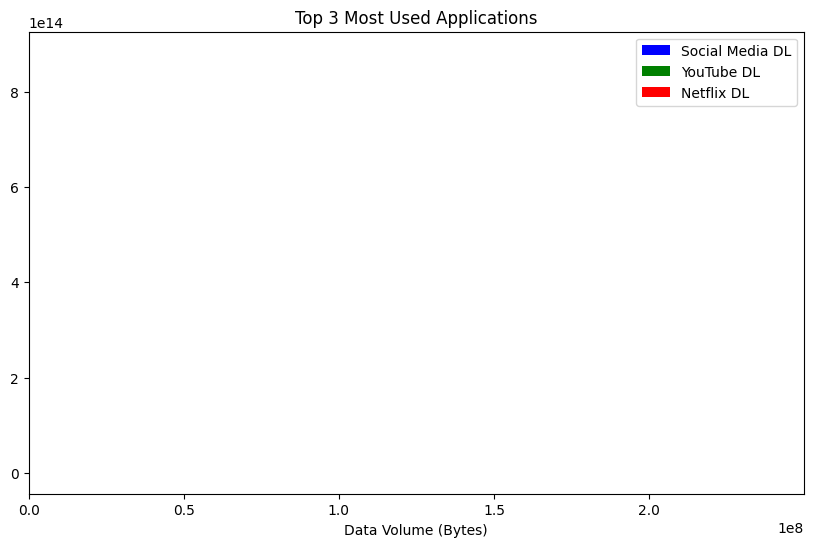

In [25]:
# Plotting the Top 3 Most Used Applications

import matplotlib.pyplot as plt

# Plot the top 3 applications by traffic
plt.figure(figsize=(10, 6))
plt.barh(app_traffic['MSISDN/Number'], app_traffic['social_media_dl'], color='blue', label='Social Media DL')
plt.barh(app_traffic['MSISDN/Number'], app_traffic['youtube_dl'], color='green', label='YouTube DL')
plt.barh(app_traffic['MSISDN/Number'], app_traffic['netflix_dl'], color='red', label='Netflix DL')
plt.xlabel('Data Volume (Bytes)')
plt.title('Top 3 Most Used Applications')
plt.legend()
plt.show()


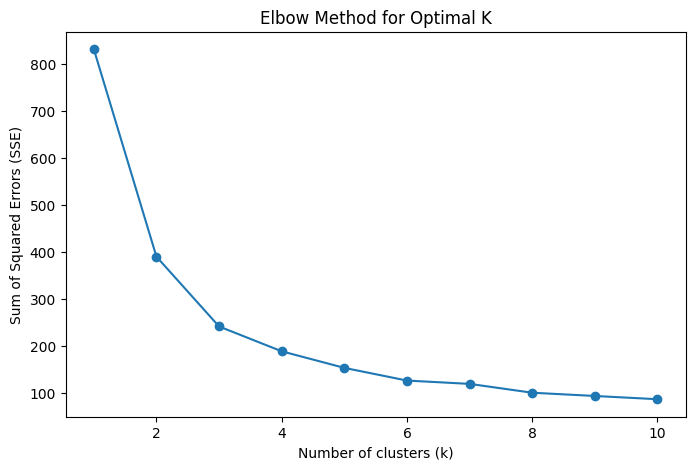

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Using elbow method to find the optimal k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    sse.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show() 
